In [32]:
# Enables figures to load outside of browser.
#%matplotlib

# Enables figures to load inline in the browser.
%matplotlib inline

In [2]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import matplotlib.ticker
import datetime
import collections

# Some matplotlib features are version dependent.
assert(matplotlib.__version__ >= '2.1.2')

In [41]:
# Depends on: pip install --upgrade google-cloud-bigquery
from google.cloud import bigquery

def run_query(query, project='mlab-sandbox'):
    #print query
    client = bigquery.Client(project=project)
    job = client.query(query)

    results = collections.defaultdict(list)
    for row in job.result(timeout=300):
        for key in row.keys():
            results[key].append(row.get(key))

    return pd.DataFrame(results)

In [4]:
def unlog(x, pos):
    v = math.pow(10, x)
    frac, whole = math.modf(v)
    if frac > 0:
        return '%.1f' % v
    else:
        return '%d' % whole

logFormatter = matplotlib.ticker.FuncFormatter(unlog)

# Daily Saturation Events @ 500Mbps

In [ ]:
df_disco = run_query("""
#standardSQL
SELECT
  name AS hostname,
  FORMAT_TIMESTAMP("%Y-%m-%d", TIMESTAMP_TRUNC(sts, DAY)) AS day,
  UNIX_SECONDS(TIMESTAMP_TRUNC(sts, DAY)) AS ts,
  SUM(IF(metric = 'switch.octets.uplink.tx' AND (value * 8 / 10000000) >= 500, 1, 0)) as saturated_events_500,
  SUM(IF(metric = 'switch.octets.uplink.tx' AND (value * 8 / 10000000) >= 800, 1, 0)) as saturated_events_800,
  SUM(IF(metric = 'switch.octets.uplink.tx' AND (value * 8 / 10000000) >= 800, 1, 0)) as saturated_events_900

FROM (
  SELECT
    metric,
    REGEXP_EXTRACT(hostname, r'(mlab[1-4].[a-z]{3}[0-9]{2}).*') AS name,
    sample.timestamp AS sts,
    sample.value AS value
  FROM
    `mlab-sandbox.base_tables.switch*`,
    UNNEST(sample) AS sample
  WHERE
    metric LIKE 'switch.octets.uplink.tx'
  GROUP BY
    hostname, metric, sts, value
)
WHERE
  name IS NOT NULL
GROUP BY
  hostname, day, ts
ORDER BY
  hostname, day, ts
""")

In [7]:
len(df_disco)

71262

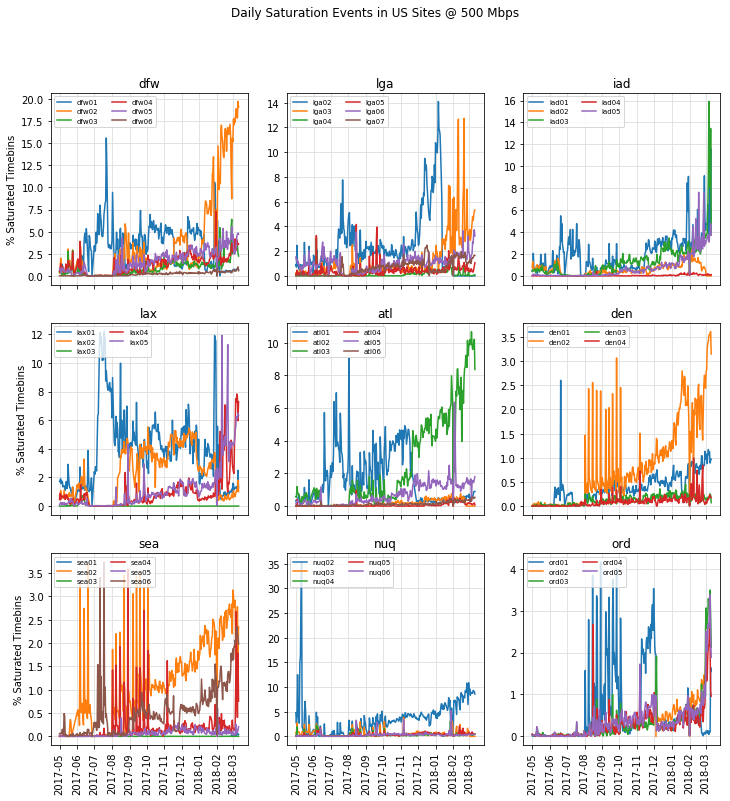

In [37]:
sites = [
    ['dfw', 'lga', 'iad'],
    ['lax', 'atl', 'den'],
    ['sea', 'nuq', 'ord'], # MIA is lower utilization.
]

cols = len(sites[0])
fig = plt.figure(figsize=(4 * cols, 4 * cols))
axes = [
    [None] * cols,
    [None] * cols,
    [None] * cols,
]

for r, siter in enumerate(sites):
    for c, site in enumerate(siter):
        #for x, rate in enumerate(['98th']):
            axes[r][c] = plt.subplot2grid((3, cols), (r, c))
            if c != 0:
                pass
            else:
                axes[r][c].set_ylabel('% Saturated Timebins')

            if r != 2:
                axes[r][c].set_xticklabels([])

            prefix = 'mlab1.' + site
            ds_sites = df_disco[ df_disco['hostname'].str.contains(prefix) ]
            for h in sorted(set(ds_sites[ ds_sites['hostname'].str.contains(prefix) ]['hostname'])):
                ds = ds_sites[ (ds_sites['hostname'].str.contains(h)) ]
                axes[r][c].plot_date(
                    dates.epoch2num(ds['ts']),
                    100 * ds['saturated_events_500'] / 8640, ls='-', ms=0, label=h[6:11])

            axes[r][c].set_title(site)
            axes[r][c].tick_params(axis='x', labelrotation=90)
            axes[r][c].grid(color='#dddddd')
            axes[r][c].legend(loc=2, fontsize='x-small', ncol=2)

fig.suptitle('Daily Saturation Events in US Sites @ 500 Mbps')
plt.show()

## Daily DISCO Uplink Utilization

In [9]:
# DISCO RATES 90th PERCENTILE

df_disco_max = run_query("""
#standardSQL
SELECT
  name AS hostname,
  FORMAT_TIMESTAMP("%Y-%m-%d", TIMESTAMP_TRUNC(sts, DAY)) AS day,
  UNIX_SECONDS(TIMESTAMP_TRUNC(sts, DAY)) AS ts,
  
  APPROX_QUANTILES(value, 101)[ORDINAL(50)] as bytes_50th,
  APPROX_QUANTILES(value, 101)[ORDINAL(90)] as bytes_90th,
  APPROX_QUANTILES(value, 101)[ORDINAL(98)] as bytes_98th,
  APPROX_QUANTILES(value, 101)[ORDINAL(99)] as bytes_99th,
  MAX(value) as bytes_max

FROM (
  SELECT
    metric,
    REGEXP_EXTRACT(hostname, r'(mlab[1-4].[a-z]{3}[0-9]{2}).*') AS name,
    sample.timestamp AS sts,
    sample.value AS value
  FROM
    `measurement-lab.base_tables.switch*`,
    UNNEST(sample) AS sample
  WHERE
    metric LIKE 'switch.octets.uplink.tx'
  GROUP BY
    hostname, metric, sts, value
)
WHERE
  name IS NOT NULL
GROUP BY
  hostname, day, ts
ORDER BY
  hostname, day, ts
""")

## Sidestream Connection counts

In [15]:
df_ss_count = run_query(
    """#standardSQL                                                                    
CREATE TEMPORARY FUNCTION sliceFromIP(ipaddr STRING)
    AS ( MOD(CAST(REGEXP_EXTRACT(ipaddr, r'[:.]([0-9]+)$') AS INT64), 64) - 10 );


SELECT
   hostname, ts, count(*) as count
FROM (
    SELECT
        REGEXP_EXTRACT(test_id, r"\d\d\d\d/\d\d/\d\d/(mlab[1-4].[a-z]{3}[0-9]{2})") AS hostname,
        UNIX_SECONDS(TIMESTAMP_TRUNC(log_time, DAY)) AS ts                            
    FROM
        -- NOTE: some tables may be reset, removed, or have partial data.
        -- `mlab-sandbox.batch.sidestream*`                                              
        -- `mlab-sandbox.gfr.sidestream_*`
         `measurement-lab.batch.sidestream`
    WHERE
      REGEXP_CONTAINS(test_id, r"mlab1.(dfw|lga|iad|lax|atl|nuq)[0-9]{2}.*")     
      --AND sliceFromIP(web100_log_entry.connection_spec.local_ip) = 7
      AND web100_log_entry.snap.HCThruOctetsAcked >= 1000000 -- 819200                          
      AND (web100_log_entry.snap.SndLimTimeRwin +                                   
        web100_log_entry.snap.SndLimTimeCwnd +                                      
        web100_log_entry.snap.SndLimTimeSnd) >= 9000000                             
      AND (web100_log_entry.snap.SndLimTimeRwin +                                   
        web100_log_entry.snap.SndLimTimeCwnd +                                      
        web100_log_entry.snap.SndLimTimeSnd) < 600000000                            
      AND (web100_log_entry.snap.State = 1 OR                                       
        (web100_log_entry.snap.State >= 5 AND                                       
        web100_log_entry.snap.State <= 11))

    GROUP BY
      hostname, ts, web100_log_entry.connection_spec.remote_ip, web100_log_entry.connection_spec.remote_port, web100_log_entry.connection_spec.local_port, web100_log_entry.connection_spec.local_ip
)

GROUP BY
  hostname, ts
ORDER BY
  hostname, ts
    """)

In [16]:
print len(df_ss_count)

1031


# Daily Uplink Utilization & Sidestream Connection Counts for SK

In [18]:
# MIA, DEN, and SEA are relatively low utilization.
# NUQ, ORD show trends less dramatic than those below.
# LGA usage appeared to dramatically lower around 2018-01. I think this is a bug, since uplink utilization remains high.

# Highest utilization sites.
sites = [
    'dfw', 'iad', 'lax', 'atl'
]

cols = len(sites)
fig = plt.figure(figsize=(4 * cols, 6))
axes = [
    [None] * cols,
    [None] * cols,
]

for c, site in enumerate(sites):
    axes[0][c] = plt.subplot2grid((2, cols), (0, c))
    axes[1][c] = plt.subplot2grid((2, cols), (1, c))
    prefix = 'mlab1.' + site

    r = 0
    if c > 0:
        # Hide ylabels after the first column.
        axes[r][c].set_yticklabels([])
    else:
        axes[r][c].set_ylabel('Mbps')

    # Extract all hostnames that contain the "mlab1.<site>" prefix.
    ds_sites = df_disco_max[ df_disco_max['hostname'].str.contains(prefix) ]
    for host in sorted(set(ds_sites['hostname'])):
        # Plot each host on the current axis.
        ds = ds_sites[ (ds_sites['hostname'].str.contains(host)) ]
        axes[r][c].plot_date(
            dates.epoch2num(ds['ts']),
            ds['bytes_90th'] * 8 / 10000000,
            ls='-', ms=0, label=host[6:11] + '-90th')

    axes[r][c].set_title(site)
    axes[r][c].set_ylim(100, 1000)
    axes[r][c].set_xticklabels([])
    axes[r][c].tick_params(axis='x', labelrotation=90)
    axes[r][c].grid(color='#dddddd')
    axes[r][c].legend(loc=2, fontsize='x-small', ncol=2)
    
    r = 1
    if c > 0:
        axes[r][c].set_yticklabels([])
    else:
        axes[r][c].set_ylabel('Connection Counts')

    ds_sites = df_ss_count[ df_ss_count['hostname'].str.contains(prefix) ]
    for host in sorted(set(ds_sites['hostname'])):
        ds = ds_sites[ (ds_sites['hostname'].str.contains(host)) ]
        axes[r][c].plot_date(
            dates.epoch2num(ds['ts']),
            ds['count'],
            ls='-', ms=0, label=host[6:11])

    axes[r][c].set_ylim(0, 25000)
    axes[r][c].tick_params(axis='x', labelrotation=90)
    axes[r][c].grid(color='#dddddd')
    axes[r][c].legend(loc=2, fontsize='x-small', ncol=2)            

fig.suptitle('Daily 98th Percentile Switch Traffic & TCP Connection Counts Per Metro')
plt.show()

# Flow-Control Trial (measurement-lab.public)

In [19]:
df_ss_trial = run_query("""
#standardSQL                                                                    
    -- Only works for mlab1 addresses. May not work on all machines.
CREATE TEMPORARY FUNCTION sliceFromIP(ipaddr STRING)
    AS ( MOD(CAST(REGEXP_EXTRACT(ipaddr, r'[:.]([0-9]+)$') AS INT64), 64) - 10 );

CREATE TEMPORARY FUNCTION betweenTimes(ts INT64, starttime STRING, endtime STRING)
    AS ( TIMESTAMP_SECONDS(ts) >= TIMESTAMP(starttime) AND TIMESTAMP_SECONDS(ts) <= TIMESTAMP(endtime) );

SELECT
    CASE 
        WHEN sliceFromIP(web100_log_entry.connection_spec.local_ip) = 1 THEN 'ndt'
        WHEN sliceFromIP(web100_log_entry.connection_spec.local_ip) = 7 THEN 'samknows'
        WHEN sliceFromIP(web100_log_entry.connection_spec.local_ip) = 9 THEN 'neubot'
        ELSE 'other' 
    END AS slice,
    CASE
        WHEN betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-01-26 00:00:00", "2018-01-27 00:00:00") THEN '5w'
        WHEN betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-02-02 00:00:00", "2018-02-03 00:00:00") THEN '4w'
        WHEN betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-02-09 00:00:00", "2018-02-10 00:00:00") THEN '3w'
        WHEN betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-02-16 00:00:00", "2018-02-17 00:00:00") THEN '2w'
        WHEN betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-02-23 00:00:00", "2018-02-24 00:00:00") THEN '1w'
        WHEN betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-03-02 00:00:00", "2018-03-03 00:00:00") THEN '0w'
        WHEN betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-03-09 00:00:00", "2018-03-10 00:00:00") THEN '+1w'
    ELSE 'unknown'                                                                    
    END AS period,
    REGEXP_EXTRACT(test_id, r"\d\d\d\d/\d\d/\d\d/(mlab[1-4].[a-z]{3}[0-9]{2})") AS hostname,
    web100_log_entry.snap.StartTimeStamp AS ts,                                   
    8 * (web100_log_entry.snap.HCThruOctetsAcked /                                
      (web100_log_entry.snap.SndLimTimeRwin +                                     
       web100_log_entry.snap.SndLimTimeCwnd +                                      
       web100_log_entry.snap.SndLimTimeSnd)) as rate_mbps   
FROM
   -- `measurement-lab.public.sidestream`
   -- `mlab-sandbox.batch.sidestream*`
    `mlab-sandbox.gfr.sidestream_*`
WHERE
        (  betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-01-26 00:00:00", "2018-01-27 00:00:00")
        OR betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-02-02 00:00:00", "2018-02-03 00:00:00")
        OR betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-02-09 00:00:00", "2018-02-10 00:00:00")
        OR betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-02-16 00:00:00", "2018-02-17 00:00:00")
        OR betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-02-23 00:00:00", "2018-02-24 00:00:00")
        OR betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-03-02 00:00:00", "2018-03-03 00:00:00")
        OR betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-03-09 00:00:00", "2018-03-10 00:00:00")
        )
  AND REGEXP_CONTAINS(test_id, r"mlab1.(dfw\d\d)")
  AND web100_log_entry.snap.HCThruOctetsAcked >= 1000000 -- 819200                          
  AND (web100_log_entry.snap.SndLimTimeRwin +                                   
    web100_log_entry.snap.SndLimTimeCwnd +                                      
    web100_log_entry.snap.SndLimTimeSnd) >= 9000000                             
  AND (web100_log_entry.snap.SndLimTimeRwin +                                   
    web100_log_entry.snap.SndLimTimeCwnd +                                      
    web100_log_entry.snap.SndLimTimeSnd) < 600000000                            
  AND (web100_log_entry.snap.State = 1 OR                                       
    (web100_log_entry.snap.State >= 5 AND                                       
    web100_log_entry.snap.State <= 11))
    
GROUP BY
  hostname, slice, period, ts, rate_mbps
""")

In [20]:
df_ss_trial_pct = run_query("""

CREATE TEMPORARY FUNCTION betweenTimes(ts INT64, starttime STRING, endtime STRING)
    AS ( TIMESTAMP_SECONDS(ts) >= TIMESTAMP(starttime) AND TIMESTAMP_SECONDS(ts) <= TIMESTAMP(endtime) );

SELECT
CASE
WHEN betweenTimes(StartTimeStamp, "2018-02-16 00:00:00", "2018-02-17 00:00:00") THEN CONCAT(sitename, '-2w')
WHEN betweenTimes(StartTimeStamp, "2018-02-23 00:00:00", "2018-02-24 00:00:00") THEN CONCAT(sitename, '-1w')
WHEN betweenTimes(StartTimeStamp, "2018-03-02 00:00:00", "2018-03-03 00:00:00") THEN CONCAT(sitename, '-0w (flow)')
ELSE 'unknown'
END AS test_period,

round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(10)], 2) as q10,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(12)], 2) as q12,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(15)], 2) as q15,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(18)], 2) as q18,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(20)], 2) as q20,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(22)], 2) as q22,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(25)], 2) as q25,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(28)], 2) as q28,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(30)], 2) as q30,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(32)], 2) as q32,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(35)], 2) as q35,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(38)], 2) as q38,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(40)], 2) as q40,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(42)], 2) as q42,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(45)], 2) as q45,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(48)], 2) as q48,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(50)], 2) as q50,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(52)], 2) as q52,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(55)], 2) as q55,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(58)], 2) as q58,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(60)], 2) as q60,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(62)], 2) as q62,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(65)], 2) as q65,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(68)], 2) as q68,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(70)], 2) as q70,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(72)], 2) as q72,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(75)], 2) as q75,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(78)], 2) as q78,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(80)], 2) as q80,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(82)], 2) as q82,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(85)], 2) as q85,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(88)], 2) as q88,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(90)], 2) as q90,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(92)], 2) as q92,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(95)], 2) as q95,
round(APPROX_QUANTILES(rate_mbps, 101) [ORDINAL(98)], 2) as q98

FROM
(
SELECT
    UNIX_SECONDS(TIMESTAMP_TRUNC(log_time, DAY)) as StartTimeStamp,
    --  web100_log_entry.snap.StartTimeStamp as StartTimeStamp,
    REGEXP_EXTRACT(test_id, r"\d\d\d\d/\d\d/[0-9]+/mlab1.(dfw02|lga03)/.*") AS sitename,
    8 * (
        web100_log_entry.snap.HCThruOctetsAcked / (
        web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd)
    ) AS rate_mbps
FROM
    -- `mlab-sandbox.batch.sidestream*`
     `mlab-sandbox.gfr.sidestream_*`
WHERE

    REGEXP_CONTAINS(test_id, r"\d\d\d\d/\d\d/[0-9]+/mlab1.(dfw02|lga03)/.*")
    AND (
             betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-02-16 00:00:00", "2018-02-17 00:00:00")
          OR betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-02-23 00:00:00", "2018-02-24 00:00:00")
          OR betweenTimes(web100_log_entry.snap.StartTimeStamp, "2018-03-02 00:00:00", "2018-03-03 00:00:00"))
    AND web100_log_entry.snap.HCThruOctetsAcked >= 819200
    AND ( web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) >= 9000000
    AND ( web100_log_entry.snap.SndLimTimeRwin + web100_log_entry.snap.SndLimTimeCwnd + web100_log_entry.snap.SndLimTimeSnd) < 600000000
    AND ( web100_log_entry.snap.State = 1 OR ( web100_log_entry.snap.State >= 5 AND web100_log_entry.snap.State <= 11))
)
GROUP BY
    sitename, test_period
ORDER BY
    sitename, test_period
""")

In [21]:
# Transpose the long list of quantiles.

# Save test_period names, so we can name the quantile values after transpose.
test_periods = df_ss_trial_pct['test_period']

n = df_ss_trial_pct.drop(['test_period'], axis=1)
t = n.transpose()
t.columns = test_periods

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(11,6))

# Reformat the percentile column names as integer numbers.
percentiles = [int(v[1:]) for v in list(sorted(n.keys()))]
for period in test_periods:
    axes.plot(percentiles, t[period], label=period)

axes.legend(loc=2)
axes.set_ylabel('Mbps')
axes.set_xlabel('Percentiles')
axes.grid(color='#dddddd')
fig.suptitle('Sidestream comparing Flow-control trial to earlier periods')
plt.show()

# Historical (mlab-sandbox.batch) - Sidestream by Period & Slice

# Variations, for each period:

* all sidestream connections from each period.
* all sidestream connections from each period and slice
* all sidestream connections from each period and slice and from same cohort.
* some sidestream connections from each period and slice and from same cohort, grouped by ts & remote_ip.
* some sidestream connections from each period and slice and from same cohort, grouped by only by remote_ip.


In [22]:
hosts = [
     'mlab1.dfw02', 'mlab1.dfw05',
     'mlab1.iad01', 'mlab1.iad02', 'mlab1.iad03', 'mlab1.iad04', 'mlab1.iad05',
     'mlab1.lax02', 'mlab1.lax03', 'mlab1.lax04', 'mlab1.lax05',
     'mlab1.lga02', 'mlab1.lga03', 'mlab1.lga04', 'mlab1.lga05', 'mlab1.lga06',
     'mlab1.atl02', 'mlab1.atl03', 'mlab1.atl04', 'mlab1.atl05',
]

hosts = [
    'mlab1.dfw02'
]

#   (datetime.datetime(2017,  8, 23), datetime.datetime(2017,   8, 28)),
#   (datetime.datetime(2017,  8, 28), datetime.datetime(2017,  10, 14)),
periods_list = [
    (datetime.datetime(2017, 10, 14), datetime.datetime(2017,  12, 7)),
    (datetime.datetime(2017, 12,  7), datetime.datetime(2018,  1,  12)),
    (datetime.datetime(2018,  1, 12), datetime.datetime(2018,  1,  21)),
    (datetime.datetime(2018,  1, 21), datetime.datetime(2018,  2,  1)),
    (datetime.datetime(2018,  2, 1),  datetime.datetime(2018,  3,  1)),
    (datetime.datetime(2018,  3, 1),  datetime.datetime(2018,  3,  10)),
]

In [ ]:
df_disco_discards = run_query("""
#standardSQL
SELECT
  name AS hostname,
  FORMAT_TIMESTAMP("%Y-%m-%d", TIMESTAMP_TRUNC(sts, DAY)) AS day,
  UNIX_SECONDS(TIMESTAMP_TRUNC(sts, DAY)) AS ts,
  COUNTIF(metric = 'switch.discards.uplink.tx' AND value > 0) / 8640 AS pct_discards

FROM (
  SELECT
    metric,
    REGEXP_EXTRACT(hostname, r'(mlab[1-4].[a-z]{3}[0-9]{2}).*') AS name,
    sample.timestamp AS sts,
    sample.value AS value
  FROM
    `measurement-lab.base_tables.switch*`,
    UNNEST(sample) AS sample
  WHERE
     metric LIKE 'switch.discards.uplink.tx'
  GROUP BY
    hostname, metric, sts, value
)
WHERE
  name IS NOT NULL
GROUP BY
  hostname, day, ts
ORDER BY
  hostname, day, ts
""")


In [ ]:
# STREAMS WITH MATCHING COHORTS
def start_and_end(d):
    s = d.strftime("%Y-%m-%d %H:%M:%S")
    e = (d + datetime.timedelta(days=4)).strftime("%Y-%m-%d %H:%M:%S")
    return s, e

df_hosts = collections.defaultdict(collections.defaultdict)
for i, periods in enumerate(periods_list):
    a_s, a_e = start_and_end(periods[0])
    b_s, b_e = start_and_end(periods[1])
    for host in hosts:
        result = run_query("""
#standardSQL

-- Only works for mlab1 addresses. May not work on all machines.
CREATE TEMPORARY FUNCTION sliceFromIP(ipaddr STRING)
    AS ( MOD(CAST(REGEXP_EXTRACT(ipaddr, r'[:.]([0-9]+)$') AS INT64), 64) - 10 );

CREATE TEMPORARY FUNCTION betweenTimes(ts INT64, starttime STRING, endtime STRING)
    AS ( TIMESTAMP_SECONDS(ts) >= TIMESTAMP(starttime) AND TIMESTAMP_SECONDS(ts) <= TIMESTAMP(endtime) );

SELECT
    slice,
    period,
    hostname,
    remote_ip,
    AVG(sum_rate_mbps) as sum_rate_mbps

FROM (

SELECT
   slice,
   period,
   hostname,
   remote_ip,
   --AVG(rate_mbps) as rate_mbps,
   --APPROX_QUANTILES(rate_mbps, 101)[ORDINAL(50)] as med_rate_mbps,
   --MAX(rate_mbps) as max_rate_mbps,
   SUM(rate_mbps) as sum_rate_mbps
    
FROM (

SELECT
    web100_log_entry.connection_spec.remote_ip as remote_ip,
    CASE 
        WHEN sliceFromIP(web100_log_entry.connection_spec.local_ip) = 1 THEN 'ndt'
        WHEN sliceFromIP(web100_log_entry.connection_spec.local_ip) = 7 THEN 'samknows'
        WHEN sliceFromIP(web100_log_entry.connection_spec.local_ip) = 9 THEN 'neubot'
        ELSE 'other' 
    END AS slice,
    CASE                                                                          
        WHEN betweenTimes(web100_log_entry.snap.StartTimeStamp, '"""+a_s+"""', '"""+a_e+"""')
            THEN '"""+a_s+"""'
        WHEN betweenTimes(web100_log_entry.snap.StartTimeStamp, '"""+b_s+"""', '"""+b_e+"""')
            THEN '"""+b_s+"""'
    ELSE 'bad'                                                                    
    END AS period,
    REGEXP_EXTRACT(test_id, r"\d\d\d\d/\d\d/\d\d/(mlab[1-4].[a-z]{3}[0-9]{2})") AS hostname,
    web100_log_entry.snap.StartTimeStamp AS ts,                                   
    8 * (web100_log_entry.snap.HCThruOctetsAcked /                                
      (web100_log_entry.snap.SndLimTimeRwin +                                     
       web100_log_entry.snap.SndLimTimeCwnd +                                      
       web100_log_entry.snap.SndLimTimeSnd)) as rate_mbps   
FROM
    `mlab-sandbox.batch.sidestream*`                                              
WHERE
      (test_id LIKE '%"""+host+"""%')            
  AND web100_log_entry.snap.StartTimeStamp <= 1521674526
  AND (   betweenTimes(web100_log_entry.snap.StartTimeStamp, '"""+a_s+"""', '"""+a_e+"""')
       OR betweenTimes(web100_log_entry.snap.StartTimeStamp, '"""+b_s+"""', '"""+b_e+"""'))
  AND web100_log_entry.snap.HCThruOctetsAcked >= 1000000 -- 819200                          
  AND (web100_log_entry.snap.SndLimTimeRwin +                                   
    web100_log_entry.snap.SndLimTimeCwnd +                                      
    web100_log_entry.snap.SndLimTimeSnd) >= 9000000                             
  AND (web100_log_entry.snap.SndLimTimeRwin +                                   
    web100_log_entry.snap.SndLimTimeCwnd +                                      
    web100_log_entry.snap.SndLimTimeSnd) < 600000000                            
  AND (web100_log_entry.snap.State = 1 OR                                       
    (web100_log_entry.snap.State >= 5 AND                                       
    web100_log_entry.snap.State <= 11))
  AND web100_log_entry.connection_spec.remote_ip IN(
    (SELECT
     remote_ip
    FROM (
      SELECT
         web100_log_entry.connection_spec.remote_ip as remote_ip,
         count(*) as c1
      FROM
         `mlab-sandbox.batch.sidestream*`
      WHERE
          (test_id LIKE '%"""+host+"""%')
            AND    web100_log_entry.snap.StartTimeStamp <= 1521674526
        AND betweenTimes(web100_log_entry.snap.StartTimeStamp, '"""+a_s+"""', '"""+a_e+"""')
        AND sliceFromIP(web100_log_entry.connection_spec.local_ip) = 7
        AND web100_log_entry.snap.HCThruOctetsAcked >= 819200                          
        AND (web100_log_entry.snap.SndLimTimeRwin +                                   
            web100_log_entry.snap.SndLimTimeCwnd +                                      
            web100_log_entry.snap.SndLimTimeSnd) >= 9000000                             
        AND (web100_log_entry.snap.SndLimTimeRwin +                                   
            web100_log_entry.snap.SndLimTimeCwnd +                                      
            web100_log_entry.snap.SndLimTimeSnd) < 600000000                            
        AND (web100_log_entry.snap.State = 1 OR                                       
            (web100_log_entry.snap.State >= 5 AND                                       
            web100_log_entry.snap.State <= 11))
      GROUP BY
        remote_ip
      HAVING c1 > 10
    ) INNER JOIN (
      SELECT
         web100_log_entry.connection_spec.remote_ip as remote_ip,
         count(*) as c2
      FROM
         `mlab-sandbox.batch.sidestream*`
      WHERE
          (test_id LIKE '%"""+host+"""%')
            AND    web100_log_entry.snap.StartTimeStamp <= 1521674526
        AND betweenTimes(web100_log_entry.snap.StartTimeStamp, '"""+b_s+"""', '"""+b_e+"""')
        AND sliceFromIP(web100_log_entry.connection_spec.local_ip) = 7
                AND web100_log_entry.snap.HCThruOctetsAcked >=  819200                          
        AND (web100_log_entry.snap.SndLimTimeRwin +                                   
            web100_log_entry.snap.SndLimTimeCwnd +                                      
            web100_log_entry.snap.SndLimTimeSnd) >= 9000000                             
        AND (web100_log_entry.snap.SndLimTimeRwin +                                   
            web100_log_entry.snap.SndLimTimeCwnd +                                      
            web100_log_entry.snap.SndLimTimeSnd) < 600000000                            
        AND (web100_log_entry.snap.State = 1 OR                                       
            (web100_log_entry.snap.State >= 5 AND                                       
            web100_log_entry.snap.State <= 11))
      GROUP BY
        remote_ip
      HAVING c2 > 10
    ) USING (remote_ip))
  )
    
GROUP BY
  hostname, slice, period, ts, web100_log_entry.connection_spec.remote_ip, rate_mbps
)

GROUP BY
  hostname, slice, period, ts,  remote_ip
  )

GROUP BY
  hostname, slice, period, remote_ip
""")
        date_i = (i, a_s, b_s)
        df_hosts[host][date_i] = result
        print 'saved', i, date_i, host, len(df_hosts[host][date_i])

## PDF, CDF, & Switch - by Site and Slice

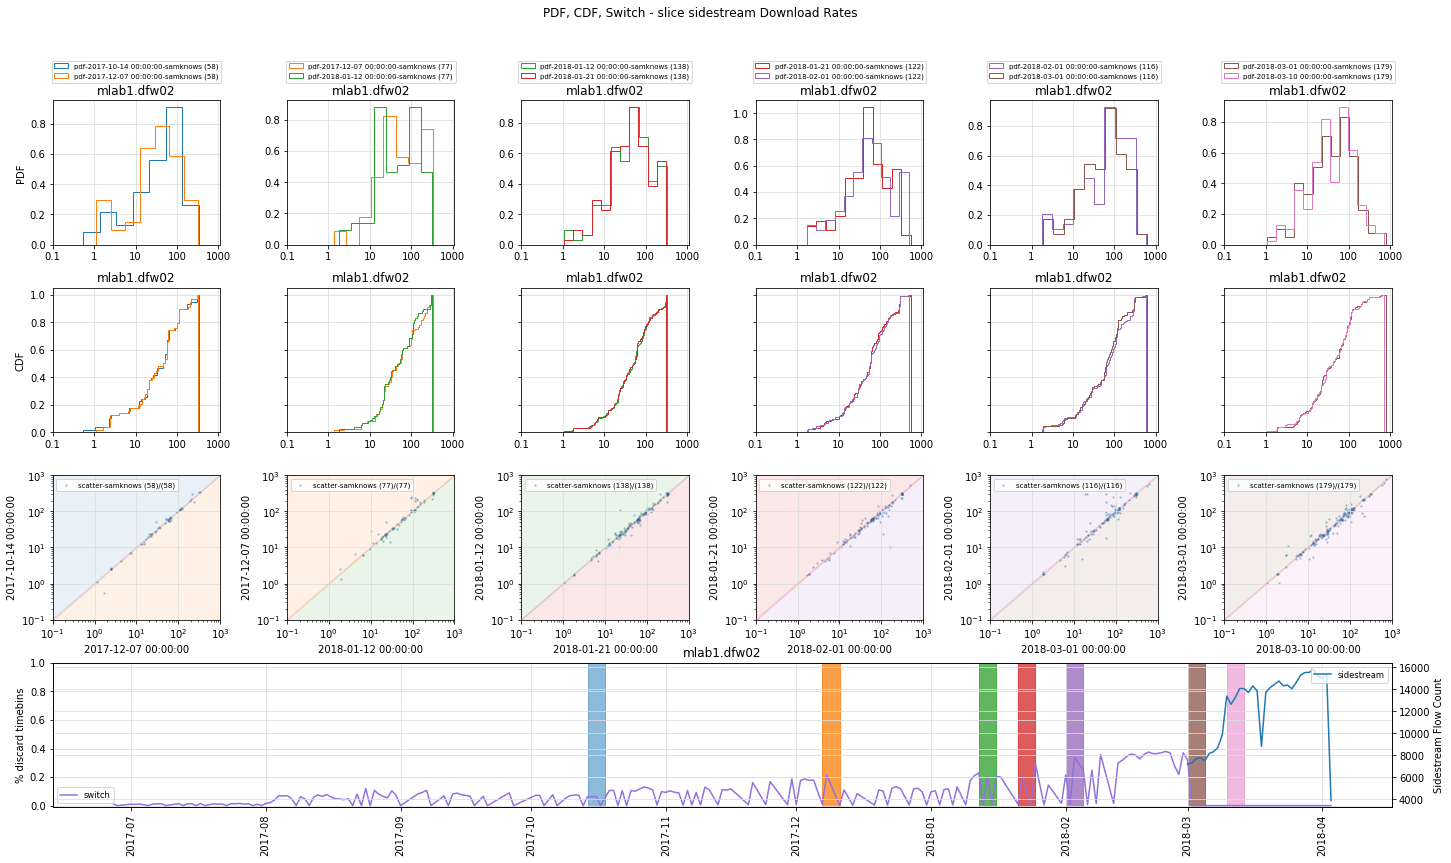

In [40]:
title = 'PDF, CDF, Switch - slice sidestream Download Rates'

label2date = {}
slices = ['samknows']
colors = plt.cm.tab10.colors
p2c = {}
c=0

for i, host in enumerate(sorted(df_hosts.keys())):
    rows = 4
    cols = len(periods_list)
    fig = plt.figure(figsize=(4 * cols, 13))
    axes = [
        [None] * cols,
        [None] * cols,
        [None] * cols,
         None,
    ]

    for p, (x, p_a, p_b) in enumerate(sorted(df_hosts[host])):
        axes[0][p] = plt.subplot2grid((rows, cols), (0, p))
        axes[1][p] = plt.subplot2grid((rows, cols), (1, p))
        axes[2][p] = plt.subplot2grid((rows, cols), (2, p))

        for k, slicename in enumerate(slices):
                
            df_ss = df_hosts[host][(x, p_a, p_b)]
            if len(df_ss) == 0:
                print 'skipping', host, 'no data'
                continue
            if len(df_ss[ df_ss['hostname'] == host ]) == 0:
                print 'skipping', host
                continue

            a = df_ss[ (df_ss['slice'] == slicename) & (df_ss['period'] == p_a) ]
            b = df_ss[ (df_ss['slice'] == slicename) & (df_ss['period'] == p_b) ]

            columns = ['hostname', 'remote_ip', 'slice']
            ds = pd.merge(a, b,  how='left', left_on=columns, right_on=columns)
            for period_str in [p_a, p_b]:
                if period_str not in p2c:
                    p2c[period_str] = colors[c]
                    c += 1

            if len(ds['sum_rate_mbps_x'].dropna()) == 0 or len(ds['sum_rate_mbps_y'].dropna()) == 0:
                continue

            # Top
            ax = axes[0][p]
            for period, l in [(p_a, ds['sum_rate_mbps_x']), (p_b, ds['sum_rate_mbps_y'])]:
                vals = [math.log10(x) for x in l.dropna()]
                period_str = period
                label = 'pdf-%s-%s (%d)' % (period_str, slicename, len(vals))
                label2date[label] = period
                    
                sqrt_bins = int(math.sqrt(len(vals)))
                n, bins, patches = ax.hist(
                    vals, sqrt_bins,
                    histtype='step', normed=1, label=label, ls='-', color=p2c[period_str])

            ax.set_axisbelow(True)
            ax.legend(fontsize='x-small', loc='upper center', bbox_to_anchor=(0.5, 1.3))
            ax.grid(color='#dddddd')
            ax.set_title(host)
            ax.xaxis.set_major_formatter(logFormatter)

            # Middle
            ax = axes[1][p]
            for period, l in [(p_a, ds['sum_rate_mbps_x']), (p_b, ds['sum_rate_mbps_y'])]:
                vals = [math.log10(x) for x in  l.dropna()]
                period_str = period
                label = 'cdf-%s-%s (%d)' % (period_str, slicename, len(vals))

                n, bins, patches = ax.hist(
                    vals, len(vals),
                    histtype='step', normed=1, cumulative=True, label=label, ls='-', color=p2c[period_str])

            ax.xaxis.set_major_formatter(logFormatter)
            ax.set_axisbelow(True)

            ax.grid(color='#dddddd')
            ax.set_title(host)
            if p != 0:
                ax.set_yticklabels([])

            # Scatter.
            ax = axes[2][p]
                    
            label = 'scatter-%s (%d)/(%d)' % (slicename, len(ds['sum_rate_mbps_x']), len(ds['sum_rate_mbps_y']))
                    
            ax.plot([0.1, 1000], [0.1, 1000], color='r', alpha=0.1)
            ax.add_patch(
                matplotlib.patches.Polygon(
                    [[.1, .1], [1000, .1], [1000, 1000], [.1, .1]], closed=True,
                    fill=True, color=p2c[p_b], alpha=0.1))
            ax.add_patch(
                matplotlib.patches.Polygon(
                    [[.1, .1], [.1, 1000], [1000, 1000], [.1, .1]], closed=True,
                    fill=True, color=p2c[p_a], alpha=0.1))
            ax.scatter(ds['sum_rate_mbps_y'], ds['sum_rate_mbps_x'], s=2, alpha=0.3, label=label)
                    
            ax.set_xlim(.1, 1000)
            ax.set_ylim(.1, 1000)
                    
            ax.set_xlabel(p_b)
            ax.set_ylabel(p_a)

            ax.grid(color='#dddddd')
            ax.semilogx()
            ax.semilogy()
            ax.legend(fontsize='x-small')

            axes[0][p].set_xlim(math.log10(.1), math.log10(1100))
            axes[1][p].set_xlim(math.log10(.1), math.log10(1100))

    # Bottom
    axes[3] = plt.subplot2grid((rows, cols), (3, 0), colspan=cols)
    ax = axes[3]
        
    ds = df_disco_discards[ df_disco_discards['hostname'] == host ]
    ax.plot_date(dates.epoch2num(ds['ts']), ds['pct_discards'], ls='-', ms=0, label='switch', color='mediumpurple')
        
    ax.set_title(host)
    ax.set_ylim(-0.01, 1)
    ax.tick_params(axis='x', labelrotation=90)
    ax.grid(color='#dddddd')
 
    # Color switch regions with the PDF periods based on legend colors.
    for p in range(0, len(df_hosts[host])):
        h, l = axes[0][p].get_legend_handles_labels()
        for k, line in enumerate(h):
            s = label2date[l[k]]
            s = datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S")
            e = s + datetime.timedelta(days=4)
            color = h[k].get_edgecolor()
            ax.axvspan(dates.date2num(s), dates.date2num(e), alpha=0.5, color=color)

    ax.set_ylabel('% discard timebins')                
    ax2 = ax.twinx()
        
    ds = df_ss_count[ df_ss_count['hostname'] == host ]
            
    ax2.plot_date(dates.epoch2num(ds['ts']), ds['count'], ls='-', ms=0, label='sidestream')
    ax2.set_ylabel('Sidestream Flow Count')
    ax2.grid(color='#dddddd')
            
    ax.legend(loc=3, fontsize='small') 
    ax2.legend(loc=1, fontsize='small') 

     
    axes[0][0].set_ylabel('PDF')
    axes[1][0].set_ylabel('CDF')  

    fig.suptitle(title)
    fig.subplots_adjust(hspace=0.3, wspace=0.4)
    plt.show()